In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.optimize import curve_fit


import math
from skimage import color
from skimage.io import imread
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import skimage.draw as sdraw
from skimage.util import img_as_ubyte

from skimage.morphology import binary_closing, disk
import scipy.ndimage as nd
import skimage.draw as sdraw

from matplotlib import colors
from skimage.measure import label, regionprops

In [15]:
#6ms 20FA
DICOM1 = 'NPERIODIC_140423_1.MR.0003.0001.2023.04.14.15.23.33.996403.63216740.IMA'
DICOM2 = 'NPERIODIC_140423_1.MR.0003.0002.2023.04.14.15.23.33.996403.63216758.IMA'
DICOM3 = 'NPERIODIC_140423_1.MR.0003.0003.2023.04.14.15.23.33.996403.63216776.IMA'
DICOM4 = 'NPERIODIC_140423_1.MR.0003.0004.2023.04.14.15.23.33.996403.63216794.IMA'
DICOM5 = 'NPERIODIC_140423_1.MR.0003.0005.2023.04.14.15.23.33.996403.63216812.IMA'
DICOM6 = 'NPERIODIC_140423_1.MR.0003.0006.2023.04.14.15.23.33.996403.63216830.IMA'
DICOM7 = 'NPERIODIC_140423_1.MR.0003.0007.2023.04.14.15.23.33.996403.63216848.IMA'
DICOM8 = 'NPERIODIC_140423_1.MR.0003.0008.2023.04.14.15.23.33.996403.63216866.IMA'
DICOM9 = 'NPERIODIC_140423_1.MR.0003.0009.2023.04.14.15.23.33.996403.63216884.IMA'
DICOM10 = 'NPERIODIC_140423_1.MR.0003.0010.2023.04.14.15.23.33.996403.63216902.IMA'
DICOM11 = 'NPERIODIC_140423_1.MR.0003.0011.2023.04.14.15.23.33.996403.63216920.IMA'
DICOM12 = 'NPERIODIC_140423_1.MR.0003.0012.2023.04.14.15.23.33.996403.63216938.IMA'
DICOMFILENAME = [DICOM1,DICOM2,DICOM3,DICOM4,DICOM5,DICOM6,DICOM7,DICOM8,DICOM9,DICOM10,DICOM11,DICOM12]

In [10]:
# a = 7766
# DICOMFILENAME = []
# for i in range (0,12):
#     DICOM1 = 'NPERIODIC_140423_1.MR.0004.000'+str(int(i+1))+'.2023.04.14.15.23.33.996403.6321'+str(a+18*i)+'.IMA'
#     DICOMFILENAME.append(DICOM1)

In [11]:
DICOMFILENAME

['NPERIODIC_140423_1.MR.0003.0001.2023.04.14.15.23.33.996403.63216740.IMA',
 'NPERIODIC_140423_1.MR.0003.0002.2023.04.14.15.23.33.996403.63216758.IMA',
 'NPERIODIC_140423_1.MR.0003.0003.2023.04.14.15.23.33.996403.63216776.IMA',
 'NPERIODIC_140423_1.MR.0003.0004.2023.04.14.15.23.33.996403.63216794.IMA',
 'NPERIODIC_140423_1.MR.0003.0005.2023.04.14.15.23.33.996403.63216812.IMA',
 'NPERIODIC_140423_1.MR.0003.0006.2023.04.14.15.23.33.996403.63216830.IMA',
 'NPERIODIC_140423_1.MR.0003.0007.2023.04.14.15.23.33.996403.63216848.IMA',
 'NPERIODIC_140423_1.MR.0003.0008.2023.04.14.15.23.33.996403.63216866.IMA',
 'NPERIODIC_140423_1.MR.0003.0009.2023.04.14.15.23.33.996403.63216884.IMA',
 'NPERIODIC_140423_1.MR.0003.0010.2023.04.14.15.23.33.996403.63216902.IMA',
 'NPERIODIC_140423_1.MR.0003.0011.2023.04.14.15.23.33.996403.63216920.IMA',
 'NPERIODIC_140423_1.MR.0003.0012.2023.04.14.15.23.33.996403.63216938.IMA']

In [30]:
#6ms 40FA
DICOM1 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0001.2023.04.14.15.23.33.996403.63217766.IMA'
DICOM2 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0002.2023.04.14.15.23.33.996403.63217784.IMA'
DICOM3 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0003.2023.04.14.15.23.33.996403.63217802.IMA'
DICOM4 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0004.2023.04.14.15.23.33.996403.63217820.IMA'
DICOM5 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0005.2023.04.14.15.23.33.996403.63217838.IMA'
DICOM6 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0006.2023.04.14.15.23.33.996403.63217856.IMA'
DICOM7 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0007.2023.04.14.15.23.33.996403.63217874.IMA'
DICOM8 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0008.2023.04.14.15.23.33.996403.63217892.IMA'
DICOM9 = 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.0009.2023.04.14.15.23.33.996403.63217910.IMA'
DICOM10 ='DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.00010.2023.04.14.15.23.33.996403.63217928.IMA'
DICOM11 ='DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.00011.2023.04.14.15.23.33.996403.63217946.IMA'
DICOM12 ='DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.00012.2023.04.14.15.23.33.996403.63217964.IMA'

DICOMFILENAME = [DICOM1,DICOM2,DICOM3,DICOM4,DICOM5,DICOM6,DICOM7,DICOM8,DICOM9,DICOM10,DICOM11,DICOM12]

In [31]:
TR = 6e-3
TE = TR/2 


GOLDSTD_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
TIME = np.asarray([], dtype = float)
for i in range (0,12):
    filepath = DICOMFILENAME[i] #'DICOM/GOLDSTANDARD_6msTR_40FA/'+
    img = pydicom.read_file(filepath)
    GOLDSTD_DATA = np.append(GOLDSTD_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
    #Corresponding "time" on exponential fit for each array layer
    TIME = np.append(TIME, TE + TR*i)
GOLDSTD_DATA =  np.delete(GOLDSTD_DATA,0,0)
#pixel array for different TR stored in GOLDSTD_DATA



FileNotFoundError: [Errno 2] No such file or directory: 'DICOM/GOLDSTANDARD_6msTR_40FA/NPERIODIC_140423_1.MR.0004.00010.2023.04.14.15.23.33.996403.63217928.IMA'

In [4]:
np.shape(GOLDSTD_DATA[:,1,1])

(12,)

In [5]:
GOLDSTD_DATA[:,100,100]

array([565., 556., 551., 549., 536., 512., 494., 470., 445., 419., 379.,
       358.])

In [6]:
def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
R2StarImage = np.asarray([], dtype = float)
for x in range (0,256):
    for y in range (0,256):
        popt, pcov = curve_fit(func, TIME, GOLDSTD_DATA[:,x,y])
        PixelR2Star = popt[1]
        R2StarImage = np.append(R2StarImage, PixelR2Star)
R2StarImage = R2StarImage.reshape(256,256)


# plt.figure(1)
# plt.plot(time, F_Magnitude, marker = 'o')


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq


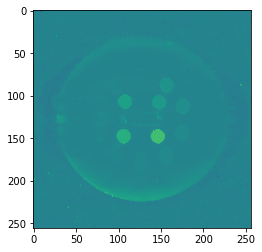

In [7]:
plt.imshow(R2StarImage)

In [8]:
R2StarImage

array([[  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [  1.        ,  -8.40884783, -15.39347748, ...,   5.55970166,
          3.86121784,   7.502364  ],
       [  1.        ,  -1.9475521 ,  -3.54736785, ...,  -1.61960931,
         -5.69472694,  -2.78761609],
       ...,
       [  1.        ,  -9.72015417,  -7.52652848, ...,  -3.6727491 ,
         -4.84405784,  -3.73700681],
       [  1.        ,   3.93331685,  -5.09466255, ...,  19.03957554,
        -11.2565324 ,   1.07056706],
       [  1.        ,   2.35539611,  -7.08094614, ...,  -1.51999007,
         -8.45776525, -10.53610069]])

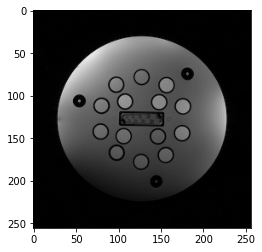

In [10]:
for i in range (0,1):
    plt.figure(i+1)
    plt.imshow(GOLDSTD_DATA[i,:,:],cmap='gray')


In [11]:
image = GOLDSTD_DATA[0,:,:]

<BarContainer object of 10 artists>

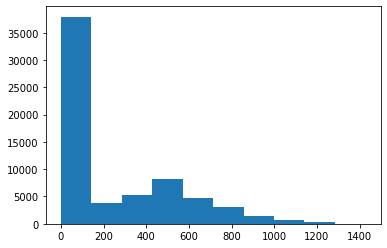

In [12]:
hist, bin_edges = np.histogram(image)
barw = bin_edges[1]-bin_edges[0] # Should be the same for all bins.
plt.bar(bin_edges[:-1], hist, width=barw, align='edge') 


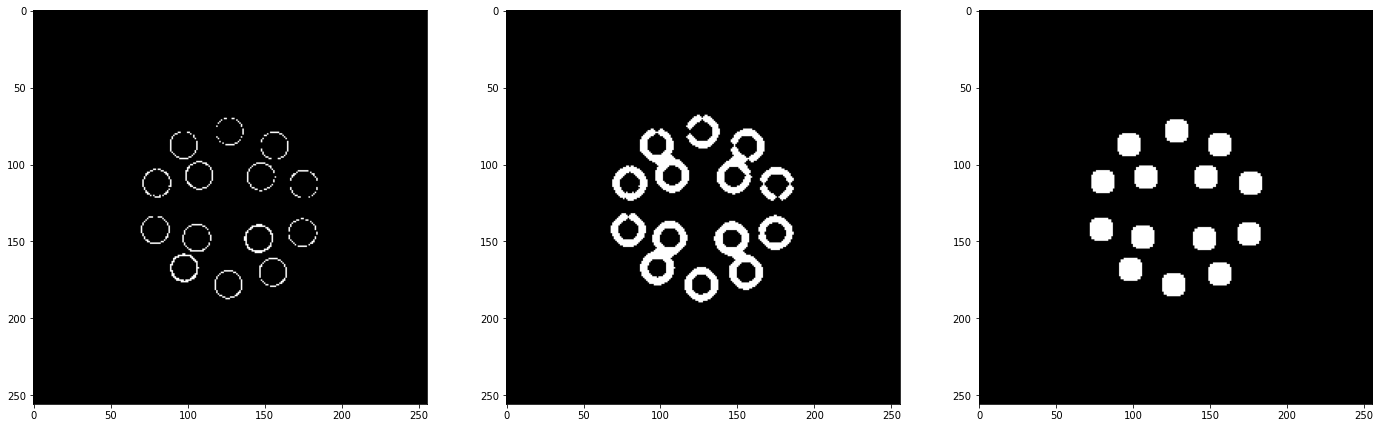

In [255]:
def multi_erosion(image, kernel, iterations):
    for i in range(iterations):
        image = erosion(image, kernel)
    return image

def multi_dilation(image, kernel, iterations):
    for i in range(iterations):
        image = dilation(image, kernel)
    return image
cross = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])
#Final Mask
MASK = np.zeros((256,256))
fig=plt.figure(figsize=(24, 8))
fig.add_subplot(1,3,1)
plt.imshow(mask, cmap='gray')

#STEP 1 Remove quare at middle and other things in the background 
mask = np.asarray(np.zeros((256,256)), dtype = float)
for x in range (0,256):
    for y in range (0,256):
        if ((GOLDSTD_DATA[1,x,y]*GOLDSTD_DATA[1,x,y]*GOLDSTD_DATA[1,x,y])<200000):
            mask[x,y] = 1
        if ((pow(x-125,2)+pow(y-125,2))>4410):
            mask[x,y] = 0
        if (x>117 and x<136 and y>90 and y<155):
            mask[x,y] = 0
#STEP 2 Closing the circles 
strel = disk(1)
I_closed = binary_closing(mask, strel)
I_closed = multi_dilation(I_closed, cross, 4)
I_closed = multi_erosion(I_closed, cross, 2)
# Closed image
fig.add_subplot(1,3,2)
plt.imshow(I_closed, cmap='gray')

#STEP 3 Draw circle on the final MASK
# skimage version 0.14.0
IMAGE = I_closed

BEST_COUNT = 14              # how many circles to draw
MIN_RADIUS = 7              # min radius should be bigger than noise
MAX_RADIUS = 20             # max radius of circles to be detected (in pixels)
LARGER_THRESH = 1.2         # circle is considered significantly larger than another one if its radius is at least so much bigger
OVERLAP_THRESH = 0.1        # circles are considered overlapping if this part of the smaller circle is overlapping

def circle_overlap_percent(centers_distance, radius1, radius2):
    '''
    Calculating the percentage area overlap between circles
    See Gist for comments:
        https://gist.github.com/amakukha/5019bfd4694304d85c617df0ca123854
    '''
    R, r = max(radius1, radius2), min(radius1, radius2)
    if centers_distance >= R + r:
        return 0.0
    elif R >= centers_distance + r:
        return 1.0
    R2, r2 = R**2, r**2
    x1 = (centers_distance**2 - R2 + r2 )/(2*centers_distance)
    x2 = abs(centers_distance - x1)
    y = math.sqrt(R2 - x1**2)
    a1 = R2 * math.atan2(y, x1) - x1*y
    if x1 <= centers_distance:
        a2 = r2 * math.atan2(y, x2) - x2*y
    else:
        a2 = math.pi * r2 - a2
    overlap_area = a1 + a2
    return overlap_area / (math.pi * r2)

def circle_overlap(c1, c2):
    d = math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)
    return circle_overlap_percent(d, c1[2], c2[2])

def inner_circle(cs, c, thresh):
    '''Is circle `c` is "inside" one of the `cs` circles?'''
    for dc in cs:
        # if new circle is larger than existing -> it's not inside
        if c[2] > dc[2]*LARGER_THRESH: continue
        # if new circle is smaller than existing one...
        if circle_overlap(dc, c)>thresh:
            # ...and there is a significant overlap -> it's inner circle
            return True
    return False

# Load picture and detect edges
image = IMAGE
edges = canny(image, sigma=3)

# Detect circles of specific radii
hough_radii = np.arange(MIN_RADIUS, MAX_RADIUS, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent circles (in order from best to worst)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

# Determine BEST_COUNT circles to be drawn
drawn_circles = []
for crcl in zip(cy, cx, radii):
    # Do not draw circles if they are mostly inside better fitting ones
    if not inner_circle(drawn_circles, crcl, OVERLAP_THRESH):
        # A good circle found: exclude smaller circles it covers
        i = 0
        while i<len(drawn_circles):
            if circle_overlap(crcl, drawn_circles[i]) > OVERLAP_THRESH:
                t = drawn_circles.pop(i)
            else:
                i += 1
        # Remember the new circle
        drawn_circles.append(crcl)
    # Stop after have found more circles than needed
    if len(drawn_circles)>BEST_COUNT:
        break

drawn_circles = drawn_circles[:BEST_COUNT]

# Actually draw circles
colors  = [(250, 0, 0), (0, 250, 0), (0, 0, 250)]
colors += [(200, 200, 0), (0, 200, 200), (200, 0, 200)]
#image = color.gray2rgb(image)
for center_y, center_x, radius in drawn_circles:
    circy, circx = sdraw.disk((center_y, center_x), radius)
    #color = colors.pop(0)
    MASK[circy, circx] = 1
    #colors.append(color)

MASK = multi_erosion(MASK, cross, 3)
fig.add_subplot(1,3,3)
plt.imshow(MASK, cmap='gray')


0.2561589869495855
0.11005555535012829
0.018918211702814956
0.0108464326210178
0.01447536896391657
0.1644601809353185
0.028466060913340138
0.1403712222120098
0.03962702953816276
0.007104683407482648
0.005070978130302222
0.1055323361281968
0.05276238805890215
0.07750757285300605


Text(0.5, 1.0, 'T2* value')

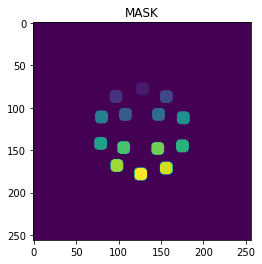

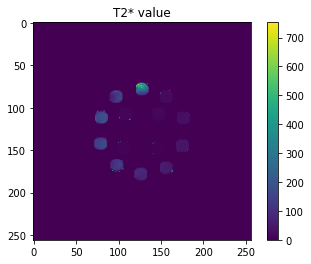

In [268]:
T2SMAP = np.zeros((256,256))
#Label the mask
P_L = label(MASK)
OneCircle = P_L
plt.imshow(P_L)

for number in range (1,15):
    T2StarMeasured = np.asarray([], dtype = float)
    
    #Generate mask of one circle
    CircleMASK = np.zeros((256,256))
    for i in range (0,256):
        for j in range (0,256):
            if(P_L[i,j]==number):
                CircleMASK[i,j] = 1

    #Only the R2* values of that circle remain
    R2MAP1 = T2StarImage*CircleMASK

    for i in range (0,256):
        for j in range (0,256):
            if(R2MAP1[i,j] > 1):
                T2StarMeasured = np.append(T2StarMeasured, 1/R2MAP1[i,j])
                #store T2*value in the T2* Map
                T2SMAP[i,j] = 1/R2MAP1[i,j]*1000 #ms

              
    #remove outliers and calcuate mean
    mean = np.mean(T2StarMeasured, axis=0)
    sd = np.std(T2StarMeasured, axis=0)

    final_list = [x for x in T2StarMeasured if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
    print(np.mean(final_list))

    
plt.figure(1)
plt.imshow(P_L)
plt.title("MASK")

plt.figure(2)
plt.imshow(T2SMAP)
plt.colorbar()
plt.title("T2* value")

In [252]:
np.max(T2SMAP)

28.090572131464732